# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)
# This script was written on Windows

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
data_train = pd.read_csv("./data_topic/train.csv",header=None) 
data_test = pd.read_csv("./data_topic/test.csv",header=None)
data_dev = pd.read_csv("./data_topic/dev.csv",header=None)

In [3]:
data_train.columns=["label","text"]
data_test.columns=["label","text"]
data_dev.columns=["label","text"]

In [4]:
data_train.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [5]:
#put the raw texts into python array

X_tr_raw = data_train.iloc[:,1]
X_te_raw  = data_test.iloc[:,1]
X_dev_raw = data_dev.iloc[:,1]


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [6]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [7]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    unigram = re.compile(token_pattern,re.I).findall(x_raw)#tokenise
    # convert words to lowercase
    for i in range(len(unigram)):
        unigram[i] = unigram[i].lower()   
    word_list = unigram[:] #make a copy of the word_list
    
    #remove stop words
    for word in unigram:   
        if word in stop_words:
            word_list.remove(word)
    
    #create ngram lists according to ngram_range
    ngram_range_list = list(range(ngram_range[0],ngram_range[1]+1))  
    x_temp=[]
    for j in ngram_range_list:
        if j==1:
            for i in range(0,len(word_list)):
                x_temp.append(word_list[i])       
        if j>1:
            for i in range(0,len(word_list)):
                if i+j <= len(word_list):
                    x_temp.append(tuple(word_list[i:i+j]))
                
    #output final result x according to vocab
    x=[]
    if vocab == set():#by default, vocab==set(),in this case, word list don't need to be processed
        x=x_temp
    else:
        vocab = list(vocab)#if given a list of vocabulary, function should return the words needed
        for element in x_temp:
            if element in vocab:
                x.append(element)

    
    return x


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [8]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=[]):
    
    #create lists for counting document frequency and collection frequency
    lists_df=[] 
    lists_cf=[]
    for x_raw in X_raw:
        temp_cf = extract_ngrams(x_raw, ngram_range,token_pattern,stop_words)
        temp_df = list(set(temp_cf)) #remove repeat element in each document for counting document frequency
        lists_cf += temp_cf
        lists_df += temp_df
    
    #count document frequency
    df = Counter()
    for ngram in lists_df:
        df[ngram] += 1
    if min_df != 0:
        df = {k:v for k,v in df.items() if v>=min_df}
        df = sorted(df.items(),key=lambda x:x[1],reverse=True)
        df = Counter(dict(df))
    
    #count collection frequency    
    cf = Counter()
    for ngram in lists_cf:
        cf[ngram] += 1
    ngram_counts = cf #ngram_counts is the collection frequency
    
    #get vocab according to keep_topN
    if keep_topN != 0:
        tmp = {k:v for k,v in ngram_counts.items()}
        tmp = sorted(tmp,key=lambda x:tmp[x],reverse=True)
        vocab = tmp[:keep_topN]
        vocab = set(vocab)
    else:
        vocab = set(lists_df)
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [9]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,1),keep_topN=10000,stop_words=stop_words)

print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

8931

['declared', 'universal', 'uae', 'quit', 'improbable', 'pledge', 'kreme', 'climax', 'ankle', 'farce', 'utterly', 'jumped', 'lorry', 'commander', 'eu', 'amat', 'edge', 'withholding', 'writer', 'seasonally', 'criticized', 'damion', 'mon', 'operative', 'bengals', 'herself', 'winner', 'should', 'clergy', 'jarno', 'cremated', 'kostas', 'exhale', 'coroibos', 'benefits', 'dispatched', 'grip', 'al', 'fullback', 'athletes', 'clear', 'ipod', 'deliver', 'grave', 'platform', 'tohmatsu', 'michigan', 'remain', 'immortality', 'approved', 'shortage', 'ten', 'prepared', 'survives', 'outlook', 'fellows', 'rolls', 'mot', 'actual', 'kill', 'shipments', 'drafty', 'evening', 'freddy', 'amanda', 'attacked', 'evident', 'tail', 'surprise', 'deeply', 'subcontractors', 'learned', 'much', 'sitting', 'heinz', 'recordings', 'developers', 'body', 'coached', 'wellington', 'formally', 'also', 'saskatchewan', 'electric', 'travis', 'ingredient', 'withdrawn', 'yet', 'beverages', 'sense', 'station', 'andruw', 'gadge

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [10]:
word2id = dict(zip(vocab,range(len(vocab))))
id2word = dict(zip(range(len(vocab)),vocab))

# set a unkown token, use the last index number as 'unknown'
word2id[str(len(word2id))] = len(word2id)
id2word[len(id2word)] = str(len(id2word))


### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [11]:
# convert texts into ngrams
X_uni_tr = []
for oneDoc in X_tr_raw:
    X_uni_tr += [extract_ngrams(oneDoc,ngram_range=(1,1), stop_words=stop_words)]

X_uni_dev = []
for oneDoc in X_dev_raw:
    X_uni_dev += [extract_ngrams(oneDoc,ngram_range=(1,1), stop_words=stop_words)]

X_uni_te = []
for oneDoc in X_te_raw:
    X_uni_te += [extract_ngrams(oneDoc,ngram_range=(1,1), stop_words=stop_words)]

In [12]:
X_uni_tr[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [13]:
#define a function to convert input document(each document represented by unigrams) into a list of vocabulary indices
def ngram2vocabIndices(X_uni,ngram_range=(1,1),vocab=set()):
    
    indices=[] # store vocabulary indices
    l = len(vocab)-1
    for oneDoc in X_uni:
        temp = []
        for word in oneDoc:
            if word in vocab: #vocab in this case is word2id
                temp += [vocab[word]]
            else: # if the word in test set or dev set are not exist in vocab, set this word to a "unknown" token  
                temp += [l]       
        indices += [temp]
        
    return indices

In [14]:
X_tr = ngram2vocabIndices(X_uni_tr,vocab=word2id)
X_dev = ngram2vocabIndices(X_uni_dev,vocab=word2id)
X_te = ngram2vocabIndices(X_uni_te,vocab=word2id)

In [15]:
X_tr[0]

[5740,
 3644,
 1011,
 6431,
 4557,
 1211,
 1230,
 7936,
 8862,
 2354,
 6418,
 3951,
 7235,
 4258,
 1129,
 8914,
 950,
 3683,
 532,
 8024,
 238,
 1889,
 210,
 8533,
 1237,
 3037,
 7239]

In [16]:
X_dev[0] # in this case 8931 represent all the word not exsited in training data

[3700,
 3427,
 8790,
 3406,
 8701,
 4853,
 3966,
 3037,
 4962,
 989,
 7166,
 1914,
 122,
 6994,
 2247,
 6731,
 8200,
 1821,
 1490,
 5884,
 4806,
 6444,
 8931,
 1039,
 3738,
 5784,
 4883,
 8931]

Put the labels `Y` for train, dev and test sets into arrays: 

In [17]:
Y_tr = np.array(data_train.iloc[:,0])
Y_te = np.array(data_test.iloc[:,0])
Y_dev = np.array(data_dev.iloc[:,0])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [18]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    W = {}
    W_emb = np.random.uniform(-0.1,0.1,(vocab_size,embedding_dim))
    W[0] = W_emb # W_emb must be the 0th in the dictionary
    index = 1 # use a flag to mark current index
    last_len = W[0].shape[1] # use a varible to store length number of last layer
    
    if hidden_dim!=[]:
        for layer in hidden_dim:
            W_hi = np.random.uniform(-0.1,0.1,(last_len,layer))
            W[index] = W_hi
            index += 1
            last_len = layer
    
        
    W_out = np.random.uniform(-1,1,(last_len,num_classes))
    W[index] = W_out

    return W
    

In [19]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)
#vocab_size:d  ,  embedding_dim:
print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [20]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [21]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [22]:
W[0]

array([[-0.0808575 ,  0.07706537,  0.02544979,  0.04468327],
       [-0.09677416,  0.01888638,  0.01135704, -0.06820807],
       [-0.0693859 ,  0.03910591, -0.03624671,  0.03839406]])

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [23]:
def softmax(z):
    if z.ndim==1:
        sig = np.exp(z)/np.sum(np.exp(z),axis=0)
    else:
        sig=[]
        for array in z:
            temp = np.exp(array)/np.sum(np.exp(array),axis=0)
            sig += [temp]
        sig = np.array(sig)        
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [24]:
def categorical_loss(y, y_preds):
    
    y = np.array(y) - 1 # Because Y_tr and Y_dev start from 1, for indexing, Y should minus 1
    if y_preds.ndim==1:
        l = -np.log(y_preds)[y]
    else:
        l_list=[]
        for i in range(len(y_preds)):
            l_temp = -np.log(y_preds[i])[y[i]]
            l_list += [l_temp]
        l = sum(l_list)/len(l_list)
    return l

In [25]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.3080264848567502


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [26]:
def relu(z):
    
    a = np.maximum(z,0)
    
    return a
    

def relu_derivative(z):
    
    dz=[]
    for ele in z:
        if ele <= 0:
            dz += [0]
        else:
            dz += [1]
    dz=np.array(dz)
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [27]:
def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.ones(size)
    zero_num = int(size * dropout_rate)
    for i in range(zero_num):
        dropout_vec[i] = 0

    np.random.shuffle(dropout_vec)
    return dropout_vec
    
    

Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [28]:
def forward_pass(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    a_reg_vecs = []
    y = 0 # initialise output y    
    x_vec_sum=0 # each vector is W[0].shape[1] x 1 ,the sum of embedding vectors is W[0].shape[1] x 1 as well
    for word_index in x: # look up the corresponding vectors in embedding matrix for every word index
        x_vec_sum += W[0][word_index] # W[0] represents embedding matrix  
    h1 = x_vec_sum/len(x) # h1 equals to avreage embedding vectors,according to formula mentioned above
    h1 = np.array(h1,dtype='float32')
   
    h_vecs += [h1]
    a1 = relu(h1)
    a1 = np.array(a1,dtype='float32')
   
    a_vecs += [a1]
    dropout_vecs1 = dropout_mask(len(a1), dropout_rate)
    dropout_vecs += [dropout_vecs1]
    a1_regularized = a1 * dropout_vecs1 # use * rather than np.dot
    a_reg_vecs += [a1_regularized]
    
    for i in range(1,len(W)):  # iterate every hidden layer
        hi = np.dot(W[i].T,a_reg_vecs[i-1])
        hi = np.array(hi,dtype='float32')
        if i != (len(W)-1): # if the forwardpass haven't come to the final layer
            h_vecs += [hi]
            ai = relu(hi)
            a_vecs += [ai]
            dropout_vec_temp = dropout_mask(len(ai), dropout_rate)
            dropout_vecs += [dropout_vec_temp]
            ai_regularized = ai * dropout_vec_temp
            a_reg_vecs += [ai_regularized]
        else: # if it is the final layer, output the y using softmax() rather than relu()
            y = softmax(hi)
            y = np.array(y,dtype='float32')
            
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['droput_vecs'] = dropout_vecs
    out_vals['y'] = y
    
    return out_vals
    

In [29]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([-0.06532356, -0.0525649 , -0.01648912,  0.03281889], dtype=float32), array([-0.00191901, -0.00136205,  0.00013134,  0.00263806,  0.00317445],
      dtype=float32)], 'a': [array([0.        , 0.        , 0.        , 0.03281889], dtype=float32), array([0.        , 0.        , 0.00013134, 0.00263806, 0.00317445],
      dtype=float32)], 'droput_vecs': [array([0., 1., 0., 1.]), array([0., 1., 1., 1., 0.])], 'y': array([0.49968764, 0.5003123 ], dtype=float32)}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [47]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False): # this function only used for two layers network
    
    i = y - 1 # in this case label y start from 1, in order to do indexing, y should minus 1
    y_preds = out_vals['y'] # probability y_hat is corresponding to the index of true label y
    y_preds[i] = y_preds[i] - 1 #  dL/dH2 = y^ - yi (yi = 1 or 0),the corresponding element should minus 1
    h1 = out_vals['h'] #in this case h would only contains one vector h1, because it is only two layers

    # the output layer
    g = y_preds #  so now we have the vector dl/dh2
    a = out_vals['a'][-1]
    dW1 = g * a.reshape(len(a),1)
    W[1] = W[1] - lr * dW1 # update the weights W[1] which is near the output layer
    
    
    #the first layer，
    #dL/dW_emb = dL/dH2 x dH2/dA1 * dA1/dH1 * dH1/dW_emb , according to chain rule
    if freeze_emb==False:
        dW0 = g.dot(W[1].T) * relu_derivative(h1[0]) * (1/len(x)) #dW0 is a vector
        for index in x: # update embedding weights accroding to input index  
            W[0][index] = W[0][index] - lr*dW0
    
    return W




Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [31]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    

    train_data = list(zip(X_tr,Y_tr))
    
    for e in range(epochs):
        np.random.shuffle(train_data) #randomise training data
        yp_train_list = [] # a 2D list of predicted y , each element is a vector after passing softmax 
        yp_dev_list = []
        
        for xi,yi in train_data:
            train_output = forward_pass(xi, W, dropout)
            W = backward_pass(xi, yi, W, train_output,lr,freeze_emb) # W is a global varible
            
            
        for xi,yi in train_data:
            train_output = forward_pass(xi, W, dropout)
            yp_train_list += [train_output['y']] 
        
        for xi in X_dev:
            dev_output = forward_pass(xi, W, dropout)
            yp_dev_list += [dev_output['y']] 
        
        Y_tr_random = [train_data[i][1] for i in range(len(train_data))] #randomised true label for tr data
        Y_tr_random = np.array(Y_tr_random)
        yp_train_list = np.array(yp_train_list) 
        yp_dev_list = np.array(yp_dev_list) 
        
        loss_tr = categorical_loss(Y_tr_random, yp_train_list)
        loss_dev = categorical_loss(Y_dev, yp_dev_list)
        training_loss_history += [loss_tr]
        validation_loss_history += [loss_dev]
        
        if abs(cur_loss_dev - loss_dev) <tolerance:
            break
        if print_progress==True:
            print("Epoch:",e,"| Training loss:",cur_loss_tr,"| Validation loss:",cur_loss_dev)
            cur_loss_tr = loss_tr
            cur_loss_dev = loss_dev
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [32]:
W = network_weights(vocab_size=len(id2word),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (8932, 300)
Shape W1 (300, 3)


In [33]:
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.002, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=300)

Epoch: 0 | Training loss: 1.0 | Validation loss: 1.0
Epoch: 1 | Training loss: 1.083648540750146 | Validation loss: 1.0888576058546702
Epoch: 2 | Training loss: 1.0642584223300218 | Validation loss: 1.0762688903013866
Epoch: 3 | Training loss: 1.0446144733577967 | Validation loss: 1.0704683323701223
Epoch: 4 | Training loss: 1.0242512222379445 | Validation loss: 1.062878748178482
Epoch: 5 | Training loss: 1.0057844543705383 | Validation loss: 1.046689027150472
Epoch: 6 | Training loss: 0.9844742592672507 | Validation loss: 1.042882864077886
Epoch: 7 | Training loss: 0.9647397878393531 | Validation loss: 1.0272008415063223
Epoch: 8 | Training loss: 0.9454896038770676 | Validation loss: 1.0146472692489623
Epoch: 9 | Training loss: 0.9265543546527624 | Validation loss: 1.0034232461452484
Epoch: 10 | Training loss: 0.9065539456283053 | Validation loss: 0.9881362215677897
Epoch: 11 | Training loss: 0.8856983471910159 | Validation loss: 0.9788456118106842
Epoch: 12 | Training loss: 0.8680866

Plot the learning process:

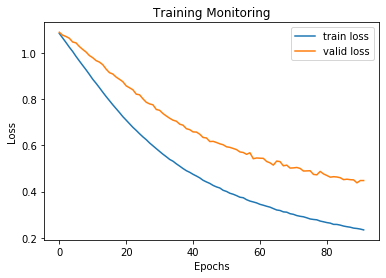

In [34]:
x=range(0,len(loss_tr))
y1=loss_tr
y2=dev_loss
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')
plt.plot(x, y1,'-',label="train loss")
plt.plot(x, y2,'-',label="valid loss")
plt.legend()

Compute accuracy, precision, recall and F1-Score:

In [35]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8488888888888889
Precision: 0.8551595134336046
Recall: 0.8488888888888889
F1-Score: 0.8492939160421709


### Discuss how did you choose model hyperparameters ? 

### Parameters Tuning Records for The Model ###


| Parameters | Precision  | Recall  | F1-Score  | Accuracy |  Comment |
|:-:|:-:|:-:|:-:|:-:|:-:|
|lr=0.01,dropout=0.2,emb_dim=300   |0.8591   |0.8522   |0.8531   |0.8522 | **a relatively good results**|
|lr=0.01,dropout=0.5,emb_dim=300   | 0.3433 |0.3414   |0.3213   |0.3324 | didn't learn, increase lr|
| lr=0.1,dropout=0.5,emb_dim=300   | 0.8541 |0.8533   |0.8534   |0.8533 | **a relatively good results**|
|lr=0.01,dropout=0.2,emb_dim=50  | 0.3759  |  0.3744 | 0.3204  |0.3744| didn't learn, increase lr||
|lr=0.1,dropout=0.2,emb_dim=50  | 0.8399  |  0.8356 | 0.8353  |0.8356|  Although result is relatively good, but loss began to increase at last few epochs, need to try increasing dropout|
|lr=0.1,dropout=0.5,emb_dim=50  |  ||||training was stopped, loss diverged|
|lr=0.1,dropout=0.2,emb_dim=500  |0.8533   | 0.8511  | 0.8511  |0.8511| **relatively good result, both train_loss and dev_loss decreased to a very value with few steps**|
|lr=0.1,dropout=0.5,emb_dim=500  |0.8577   | 0.8533  | 0.8511  |0.8511|  **relatively good result, both train_loss and dev_loss decreased to a very value with few steps**|

Firstly, to see if the loss trends are correctly decreasing, I didn't set tolerance. When I saw the validation loss and training loss kept decreasing, I can sure the SGD function are basicly correct. The next step is to choose model hyperparameters, I printed the validation loss and looked through the loss value, so that I can choose a proper value of tolerance to make sure the loss converge so effectively. The parameter tuning records table is shown above. Sometimes when learning rate is to small it doesn't learn very quickly, validation loss may be judged as converged, so when it doesn't learn, I would try to increase learning rate or use smaller tolerance. Basically, for the first model, it can achieve F1-score around 0.83--0.85. The bigger embedding size, the less epochs, but it would take very long time to compute a single epoch.  

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [36]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] += emb
    return w_emb

In [37]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

w_glove.shape

(8932, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [48]:
W_glove = network_weights(vocab_size=len(word2id),embedding_dim=300,hidden_dim=[], num_classes=3)#initialise the weights

for i in range(len(W_glove)):
    print('Shape W'+str(i), W_glove[i].shape)

W_glove[0] = w_glove # replace the weigths of the embedding matrix with w_glove

Shape W0 (8932, 300)
Shape W1 (300, 3)


In [50]:
W_glove, loss_tr_glove, dev_loss_glove = SGD(X_tr, Y_tr,
                            W_glove,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.1,
                            freeze_emb=True, # stop updating W[0]
                            tolerance=0.001,
                            epochs=500)

Epoch: 0 | Training loss: 1.0 | Validation loss: 1.0
Epoch: 1 | Training loss: 0.9136370339120428 | Validation loss: 0.906350563466549
Epoch: 2 | Training loss: 0.8560330870809655 | Validation loss: 0.8568824462095896
Epoch: 3 | Training loss: 0.8054317477873216 | Validation loss: 0.8503042661150296
Epoch: 4 | Training loss: 0.759856741965438 | Validation loss: 0.7820344890157381
Epoch: 5 | Training loss: 0.7237736781112228 | Validation loss: 0.7677977581818899
Epoch: 6 | Training loss: 0.6991021084195623 | Validation loss: 0.7337598125636577
Epoch: 7 | Training loss: 0.6770654456476526 | Validation loss: 0.6953079197307428
Epoch: 8 | Training loss: 0.647945334391358 | Validation loss: 0.6593279253443082
Epoch: 9 | Training loss: 0.6143279932090081 | Validation loss: 0.6643118913968404
Epoch: 10 | Training loss: 0.6096981692151167 | Validation loss: 0.6293257150053978
Epoch: 11 | Training loss: 0.5890490328357555 | Validation loss: 0.6583368104199568
Epoch: 12 | Training loss: 0.581391

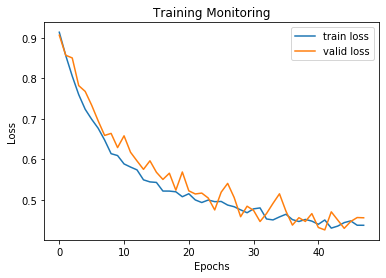

In [51]:
x=range(0,len(loss_tr_glove))
y1=loss_tr_glove
y2=dev_loss_glove
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')
plt.plot(x, y1,'-',label="train loss")
plt.plot(x, y2,'-',label="valid loss")
plt.legend()

In [52]:
preds_te = [np.argmax(forward_pass(x, W_glove, dropout_rate=0.0)['y'])+1 for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8655555555555555
Precision: 0.8676440621565756
Recall: 0.8655555555555555
F1-Score: 0.8660015472520705


### Discuss how did you choose model hyperparameters ? 

### Parameters Tuning Records for The Model 

| Parameters | Precision  | Recall  | F1-Score  | Accuracy |  Comment |
|:-:|:-:|:-:|:-:|:-:|:-:|
 | lr=0.001,dropout=0.2,emb_dim=300   |   |   |   | |stopped training, In this case I try to make tolerance 0.001, but loss kept vibrating|
 | lr=0.0001,dropout=0.2,emb_dim=300   | 0.8742 |0.8733   |0.8736   |0.8733 | **a relatively good results**|
 | lr=0.0001,dropout=0.5,emb_dim=300   | 0.8801 |0.8800   |0.8794   |0.88 | **Results were good, but loss kept vibrating**|
 | lr=0.001,dropout=0.5,emb_dim=300   |  |   |   | |stopped training, loss diverge|


In this case, I used the Glove with the embedding_size=300. At first, I tried learning_rate=0.001,dropout=0.2, default tolerance is 0.001, but loss values kept vabrating, so I used a smaller learning rate, 0.0001, and the loss started to decrease normally. 

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [42]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False): # this backward function used for bonus
    
    i = y - 1 # in this case label y start from 1, in order to do indexing, y should minus 1
    l = len(W) - 1 # the max index for W
    y_preds = out_vals['y'] # probability y_hat is corresponding to the index of true label y
    y_preds[i] = y_preds[i] - 1 #  dL/dHl = y^ - yi (yi = 1 or 0),the corresponding element should minus 1
    h = out_vals['h'] 
    
    # update the output layer weight
    g = y_preds #  so now we have the vector dl/dHl
    a = out_vals['a']
    dWl =  g * a[-1].reshape(len(a[-1]),1) # the last layer before output layer
    W[l] = W[l] - lr * dWl # update the weights W[1] which is near the output layer
    dA = W[l].dot(g)#this is dL/dA[l-1]
    
    # update the hidden layers' weights
    for i in range(l-1,0,-1): # from W[l-1] to W[1], because W[0] is pre-trained embedding matrix and don't need to be updated
        dH = relu_derivative(h[i]) * dA # layer l - 1
        dWi =  dH * a[i-1].reshape(len(a[i-1]),1) # compute gradients, dWi should have same dimension with W[i]
        W[i] = W[i] - lr * dWi
        dA = W[i].dot(dH)
   
    
    return W


In [43]:
W_extend = network_weights(vocab_size=len(word2id),embedding_dim=300,hidden_dim=[18,6], num_classes=3)#initialise the weights with 2 hidden layers

for i in range(len(W_extend)):
    print('Shape W'+str(i), W_extend[i].shape)

W_extend[0] = w_glove # replace the weigths of the embedding matrix with w_glove

Shape W0 (8932, 300)
Shape W1 (300, 18)
Shape W2 (18, 6)
Shape W3 (6, 3)


In [44]:
W_extend, loss_tr_extend, dev_loss_extend = SGD(X_tr, Y_tr,
                            W_extend,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.1,
                            freeze_emb=True, # stop updating W[0]
                            tolerance=0.0005,
                            epochs=500)

Epoch: 0 | Training loss: 1.0 | Validation loss: 1.0
Epoch: 1 | Training loss: 1.0913581935564678 | Validation loss: 1.0937944134076436
Epoch: 2 | Training loss: 1.0778123780091604 | Validation loss: 1.0839935421943665
Epoch: 3 | Training loss: 1.0511916650086641 | Validation loss: 1.0620849593480428
Epoch: 4 | Training loss: 0.998961207618316 | Validation loss: 1.010606731971105
Epoch: 5 | Training loss: 0.9198904952158531 | Validation loss: 0.9378365512688954
Epoch: 6 | Training loss: 0.8264042943902313 | Validation loss: 0.8198444966475169
Epoch: 7 | Training loss: 0.7445641990533719 | Validation loss: 0.7659697573383649
Epoch: 8 | Training loss: 0.6811176009150222 | Validation loss: 0.6939159691830477
Epoch: 9 | Training loss: 0.6267736328051736 | Validation loss: 0.5935088524222374
Epoch: 10 | Training loss: 0.5781008933034415 | Validation loss: 0.5965038308997949
Epoch: 11 | Training loss: 0.5241973004955799 | Validation loss: 0.49324225418269635
Epoch: 12 | Training loss: 0.5081

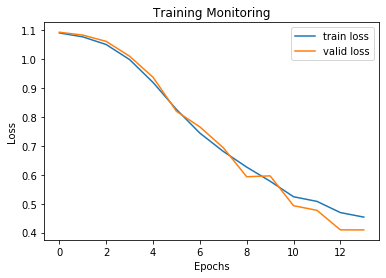

In [45]:
x=range(0,len(loss_tr_extend))
y1=loss_tr_extend
y2=dev_loss_extend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')
plt.plot(x, y1,'-',label="train loss")
plt.plot(x, y2,'-',label="valid loss")
plt.legend()

In [46]:
preds_te = [np.argmax(forward_pass(x, W_extend, dropout_rate=0.0)['y'])+1 for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8833333333333333
Precision: 0.8829641419531535
Recall: 0.8833333333333334
F1-Score: 0.8830386824903247


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.855  | 0.849  | 0.849  | 0.849  |
| Average Embedding (Pre-trained)  | 0.868  |0.866   |  0.866 |0.866   |
| Average Embedding (Pre-trained) + 2 hidden layers (BONUS)   | 0.883  | 0.883  | 0.883  | 0.883  |


In conclusion, test results are:
Average embedding, the F1-Score around 0.84 - 0.85; 
Average embedding(Pre-trained), the F1-Score around 0.86 - 0.88; 
Average embedding(Pre-trained), the F1-Score around 0.87 - 0.89; 
